In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mplimate import Imshow

# `mplimate` examples

## Play animation within notebook during runtime

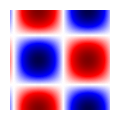

In [2]:
x = np.linspace(0, 2 * np.pi, 100)
y = np.linspace(0, 2 * np.pi, 100)
X, Y = np.meshgrid(x, y)
frames = 30
images = np.zeros((1, frames, 100, 100))

for i in range(frames):
    phase = 2 * np.pi * i / frames
    images[0, i] = np.sin(X + phase) * np.cos(Y)

anim = Imshow(images=images, sleep=0.05, cmap=plt.cm.seismic)
anim.run()

# Export the animation as a video file and embed it in the notebook

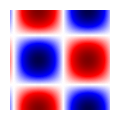

In [3]:
anim = Imshow(images=images, sleep=0.05, cmap=plt.cm.seismic)
anim.export("test.mp4", dpi=300, framerate=10, delete_if_exists=True)

In [4]:
from IPython.display import HTML

path = str(anim.path.absolute() / "test.mp4")

HTML(f"""
<video controls>
  <source src="{path}" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

## Build a new animation class

```python

class MyAnimation(Animation):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    # The key is to call a plot function in the `init` method
    def init(self, frame: int = 0) -> None:
        self.line = plt.plot([0, 1], [0, 1])

    # And to update the plotted elements in the `animate` method
    def animate(self, frame: int) -> None:
        self.line.set_data([0, frame], [0, frame])
```

### Toy example

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mplimate import Animation

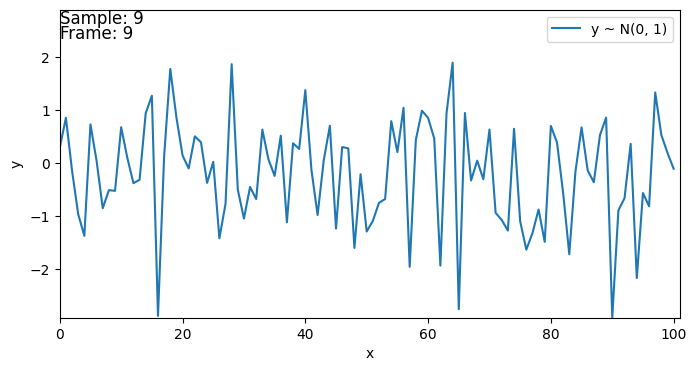

In [6]:
class MyAnimation(Animation):
    def __init__(self, n_samples, frames, *args, **kwargs):
        # The init function typically gets a data object
        # that has (n_samples, n_frames, ...).
        # Here we pass only integers n_samples and frames
        # and generate random data accordingly which the animation loops over
        super().__init__(*args, **kwargs)
        self.init_figure(None, None, [8, 4])
        self.frames = frames
        self.n_samples = n_samples

    def init(self, frame: int = 0) -> None:
        # The init function calls any matplotlib plot function
        # to initialize the plot
        # We keep track of the plot object to update it's data in the animate method
        # for fast updates (faster than re-running the plot function)
        self.line = self.ax.plot(0, np.random.randn(1), label="y ~ N(0, 1)")

        # We can add static elements to the plot here too
        self.ax.set_ylabel("y")
        self.ax.set_xlabel("x")
        self.ax.legend()

        # We can also initiate dynamic text elements
        self.sample_text = self.ax.annotate(
            f"Sample: {self.batch_sample}",
            (0, 1),
            xycoords="axes fraction",
            fontsize=12,
            va="top",
        )
        self.frame_text = self.ax.annotate(
            f"Frame: {frame}",
            (0, 0.95),
            xycoords="axes fraction",
            fontsize=12,
            va="top",
        )

    def animate(self, frame: int) -> None:
        # First we get the current data from the plot object
        x, y = self.line[0].get_data()

        # Then we update the data
        new_x = np.arange(len(y) + 1)
        new_y = np.append(y, np.random.randn(1))
        self.line[0].set_data(new_x, new_y)

        # Then we update the view limits
        xmin = np.min(new_x)
        xmax = np.max(new_x)
        ymin = np.min(new_y)
        ymax = np.max(new_y)
        # Expand the view as the line grows
        self.ax.set_xlim(xmin, xmax + 1)
        self.ax.set_ylim(ymin, ymax + 1)

        # Then we update the text elements
        self.sample_text.set_text(f"Sample: {self.batch_sample}")
        self.frame_text.set_text(f"Frame: {frame}")


anim = MyAnimation(10, 10, sleep=0.1)
anim.run()


### Time series example

In [7]:
from typing import Optional, List
from mplimate import Animation

In [8]:
class TimeSeries(Animation):
    """Animates time series data using line plots.

    Args:
        data: Array of time series to animate (n_samples, n_frames, n_series).
        x: Optional x-axis values. If None, uses range(n_frames).
        fig: Existing Figure instance or None.
        ax: Existing Axis instance or None.
        update: Whether to update the canvas after an animation step.
        figsize: Size of the figure.
        sleep: Time to sleep between frames.
        **kwargs: Additional arguments passed to plt.plot.

    Example:
        >>> # Create sample data: 2 samples, 100 frames, 3 time series each
        >>> t = np.linspace(0, 10, 100)
        >>> data = np.zeros((2, 100, 3))
        >>> for i in range(2):  # For each sample
        ...     for j in range(3):  # For each time series
        ...         phase = 2 * np.pi * i / 2 + j * np.pi / 3
        ...         data[i, :, j] = np.sin(t + phase)
        >>> anim = TimeSeries(data, x=t, sleep=0.05)
        >>> anim.run()
    """

    def __init__(
        self,
        data: np.ndarray,
        x: Optional[np.ndarray] = None,
        fig: Optional[plt.Figure] = None,
        ax: Optional[plt.Axes] = None,
        update: bool = True,
        figsize: List[int] = [8, 4],
        sleep: float = 0.01,
        **kwargs,
    ) -> None:
        super().__init__(None, fig)

        if len(data.shape) != 3:
            raise ValueError(
                f"Expected 3D array (n_samples, n_frames, n_series), got shape {data.shape}"
            )

        self.init_figure(fig, ax, figsize)
        self.data = data
        self.n_samples, self.frames, self.n_series = data.shape
        self.x = x if x is not None else np.arange(self.frames)
        self.kwargs = kwargs
        self.update = update
        self.sleep = sleep
        self.lines = []

    def init(self, frame: int = 0) -> None:
        """Initialize the animation with empty lines.

        Args:
            frame: Initial frame number (unused).
        """
        self.ax.set_xlim(self.x[0], self.x[-1])
        self.ax.set_ylim(np.min(self.data) * 1.1, np.max(self.data) * 1.1)

        # Create a line for each time series
        self.lines = []
        for i in range(self.n_series):
            (line,) = self.ax.plot([], [], **self.kwargs)
            self.lines.append(line)

    def animate(self, frame: int) -> None:
        """Animate a single frame by updating the line data.

        Args:
            frame: Frame number to animate.
        """
        # Update each line with data up to the current frame
        for i, line in enumerate(self.lines):
            line.set_data(
                self.x[: frame + 1], self.data[self.batch_sample, : frame + 1, i]
            )

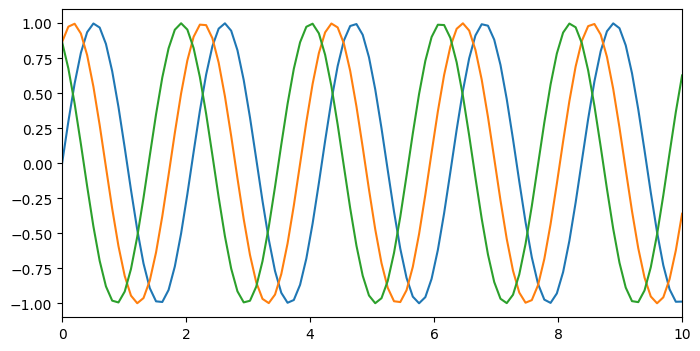

In [9]:
t = np.linspace(0, 10, 100)
data = np.zeros((3, 100, 3))  # 1 sample, 100 frames, 3 time series

# Generate three sine waves with different phases
for i in range(3):
    for j in range(3):
        phase = i * np.pi / 3
        data[j, :, i] = np.sin((j + 1) * t + phase)

# Create and run the animation
anim = TimeSeries(data, x=t, sleep=0.05)
anim.run()